## Notebook 3: LSTM for timeseries analysis

In notebook 3 we continue working on the dataframe we built in notebook 1 for 2NE1 number of searches on wikipedia during 2016 and 2017.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('DF_2NE1.CSV')

In [3]:
df.head()

,2NE1_zh.wikipedia.org_all-access_spider,date_idx
0,18,7/1/2015
1,11,7/2/2015
2,5,7/3/2015
3,13,7/4/2015
4,14,7/5/2015


In [4]:
df.dtypes

2NE1_zh.wikipedia.org_all-access_spider     int64
date_idx                                   object
dtype: object

In [5]:
df['date_idx'] = pd.to_datetime(df['date_idx'], infer_datetime_format=True)

In [6]:
df.dtypes

2NE1_zh.wikipedia.org_all-access_spider             int64
date_idx                                   datetime64[ns]
dtype: object

No handles with labels found to put in legend.


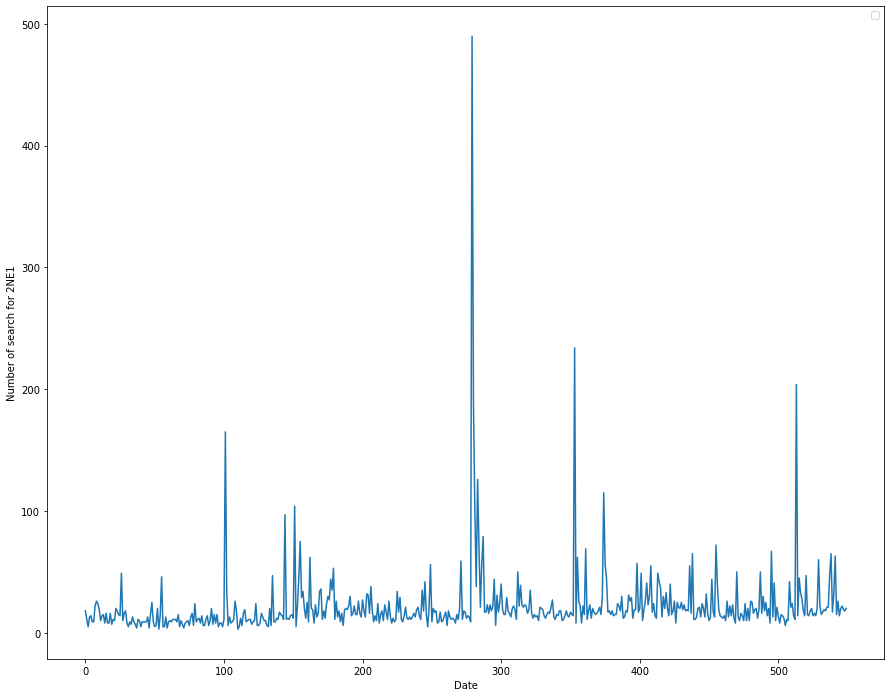

In [7]:
plt.figure(figsize=(15,12))
plt.xlabel('Date')
plt.ylabel('Number of search for 2NE1')
plt.title('')
plt.legend(loc='best')
plt.plot(df['2NE1_zh.wikipedia.org_all-access_spider'])

In [8]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [9]:
train_size = 0.8
df_train = df[:int(len(df)*0.8)]
df_test = df[int(len(df)*0.8):]

In [10]:
df_train.tail()

,2NE1_zh.wikipedia.org_all-access_spider,date_idx
435,18,2016-09-08
436,55,2016-09-09
437,16,2016-09-10
438,65,2016-09-11
439,11,2016-09-12


In [11]:
df_test.head()

,2NE1_zh.wikipedia.org_all-access_spider,date_idx
440,11,2016-09-13
441,13,2016-09-14
442,20,2016-09-15
443,21,2016-09-16
444,13,2016-09-17


In [12]:
len(df)

550

In [13]:
len(df_train)

440

In [14]:
len(df_test)

110

In [15]:
df_test.iloc[0]['2NE1_zh.wikipedia.org_all-access_spider']

11

In [16]:
df_test[0:3]['2NE1_zh.wikipedia.org_all-access_spider']

440    11
441    13
442    20
Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64

To be able to apply LSTM on timeseries data, we need to create the following data structure and feed it to the LSTM network.

| Feature 1 | Feature 2 | Feature 3 | Target Value|
| :- | :- | :- | :- |
| ts(t-3) | ts(t-2) | ts(t-1) | ts(t) |
| ts(t-2) | ts(t-1) | ts(t)   | ts(t+1)
| ts(t-1) |  ts(t)  | ts(t+1) | ts(t+2)
| ts(t) | ts(t+1) | ts(t+2)    |      ts(t+3)



In [17]:
window_size = 3
# data_X is for features, data_Y is for target value.
data_X, data_Y = [], []
for i in range(len(df_train) - window_size - 1): # 440-3-1=436
    a = df_train[i:(i + window_size)]['2NE1_zh.wikipedia.org_all-access_spider']
    data_X.append(a)
    data_Y.append(df_train.loc[i + window_size]['2NE1_zh.wikipedia.org_all-access_spider'])

In [54]:
data_X[:5]

[0    18
 1    11
 2     5
 Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64,
 1    11
 2     5
 3    13
 Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64,
 2     5
 3    13
 4    14
 Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64,
 3    13
 4    14
 5     9
 Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64,
 4    14
 5     9
 6     9
 Name: 2NE1_zh.wikipedia.org_all-access_spider, dtype: int64]

In [55]:
data_Y[:5]

[13, 14, 9, 9, 22]

In [20]:
len(data_X)

436

In [21]:
len(data_Y)

436

In [22]:
# This function can only be used for df_train. As df_test starts from 440 (its range index), 
# it will fail at dataset.loc[i + window_size][col_name]
# For df_test add df_test.index.start to i in .loc[] part.
def create_dataset(dataset, col_name = '2NE1_zh.wikipedia.org_all-access_spider', window_size = 3):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1): 
        a = dataset[i:(i + window_size)][col_name]
        data_X.append(a)
        data_Y.append(dataset.loc[i + window_size][col_name])
    return(np.array(data_X), np.array(data_Y))

In [23]:
#  df_train[436:(436 + 3)]['2NE1_zh.wikipedia.org_all-access_spider']

In [24]:
# df_train.loc[1 + 3]['2NE1_zh.wikipedia.org_all-access_spider']

In [25]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
col_name = '2NE1_zh.wikipedia.org_all-access_spider'
train_X, train_Y = create_dataset(df_train, col_name, window_size=3)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(436, 3)


In [26]:
# df_test.head()

In [27]:
# df_test[0:3]

In [28]:
# df_test.head()

In [29]:
df_test.loc[440+3]['2NE1_zh.wikipedia.org_all-access_spider']

21

In [30]:
df_test.index.start

440

In [31]:
window_size = 3
test_X, test_Y = [], []
for i in range(len(df_test) - window_size - 1): # 110-3-1=106
    a = df_test[i:(i + window_size)]['2NE1_zh.wikipedia.org_all-access_spider']
    test_X.append(a)
    test_Y.append(df_test.loc[df_test.index.start + i + window_size]['2NE1_zh.wikipedia.org_all-access_spider'])

test_X = np.array(test_X) 
test_Y = np.array(test_Y)

In [59]:
test_X[100:]

array([[[32, 63, 15]],

       [[63, 15, 26]],

       [[15, 26, 14]],

       [[26, 14, 20]],

       [[14, 20, 22]],

       [[20, 22, 19]]], dtype=int64)

In [33]:
train_X.shape

(436, 3)

### Reshaping data to feed LSTM model

In [34]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))

In [35]:
train_X.shape

(436, 1, 3)

In [36]:
train_X

array([[[18, 11,  5]],

       [[11,  5, 13]],

       [[ 5, 13, 14]],

       ...,

       [[18, 19, 18]],

       [[19, 18, 55]],

       [[18, 55, 16]]], dtype=int64)

In [37]:
test_X.shape

(106, 3)

In [38]:
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [39]:
train_X

array([[[18, 11,  5]],

       [[11,  5, 13]],

       [[ 5, 13, 14]],

       ...,

       [[18, 19, 18]],

       [[19, 18, 55]],

       [[18, 55, 16]]], dtype=int64)

In [40]:
model = Sequential()   
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")

### Question 1: Explain input shape for first layer of LSTM! How did we get to input_shape = (1, window_size)?

In [41]:
model.fit(train_X, train_Y, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
436/436 - 1s - loss: 1417.6803
Epoch 2/100
436/436 - 1s - loss: 1397.2557
Epoch 3/100
436/436 - 1s - loss: 1367.7377
Epoch 4/100
436/436 - 1s - loss: 1330.8486
Epoch 5/100
436/436 - 1s - loss: 1301.6288
Epoch 6/100
436/436 - 1s - loss: 1249.1240
Epoch 7/100
436/436 - 1s - loss: 1222.3387
Epoch 8/100
436/436 - 1s - loss: 1201.0125
Epoch 9/100
436/436 - 1s - loss: 1181.9750
Epoch 10/100
436/436 - 1s - loss: 1164.3445
Epoch 11/100
436/436 - 1s - loss: 1148.4662
Epoch 12/100
436/436 - 1s - loss: 1132.8622
Epoch 13/100
436/436 - 1s - loss: 1118.3419
Epoch 14/100
436/436 - 1s - loss: 1105.5717
Epoch 15/100
436/436 - 1s - loss: 1094.0525
Epoch 16/100
436/436 - 1s - loss: 1083.5044
Epoch 17/100
436/436 - 1s - loss: 1073.9166
Epoch 18/100
436/436 - 1s - loss: 1064.6973
Epoch 19/100
436/436 - 1s - loss: 1056.2170
Epoch 20/100
436/436 - 1s - loss: 1048.6210
Epoch 21/100
436/436 - 1s - loss: 1041.3457
Epoch 22/100
436/436 - 1s - loss: 1034.8185
Epoch 23/100
436/436 - 1s - loss: 1028.85

### Question 2: What is the relationship between epoch and batch size? Are all records fed into the network in each epoch in batches as big as batch_size? In other words, do all 436 records get into our network in each epoch in batches of size 1?

In [42]:
print(model.metrics)

In [43]:
pred = model.predict(test_X,batch_size=1, verbose=1)

106/106 [==============================] - 0s 1ms/step


In [60]:
pred[:5]

array([[19.719128],
       [21.257605],
       [23.866098],
       [23.520844],
       [21.53703 ]], dtype=float32)

In [45]:
pred[:, 0]

array([19.966005, 21.11562 , 22.84434 , 22.472294, 21.266842, 22.975874,
       21.87365 , 21.442059, 22.6131  , 21.815165, 19.20146 , 21.791636,
       22.940355, 19.32931 , 22.739433, 23.154129, 23.043371, 22.555313,
       21.685125, 21.221453, 20.960205, 20.401432, 20.510498, 22.712543,
       21.243723, 22.643448, 21.576906, 21.716608, 18.209972, 20.95894 ,
       21.769243, 20.923443, 19.909567, 22.081547, 20.60582 , 20.275536,
       22.359846, 20.085915, 21.919622, 20.846598, 23.0861  , 22.90745 ,
       21.865437, 22.745077, 22.423555, 20.888807, 22.10104 , 23.018522,
       21.730635, 23.00738 , 22.464615, 22.79118 , 21.609934, 18.209782,
       21.359459, 22.901974, 21.50001 , 22.693811, 20.231468, 21.850079,
       20.687002, 18.607347, 22.002388, 19.952698, 19.911453, 16.128855,
       18.784458, 21.460617, 23.11402 , 22.914715, 22.660938, 17.740324,
       22.373497, 23.159208, 22.211447, 23.158796, 23.141754, 23.001837,
       20.684427, 21.89334 , 22.941828, 21.778736, 

In [46]:
test_Y

array([ 21,  13,  24,  20,  13,  32,  16,  10,  13,  44,  17,  13,  72,
        40,  19,  14,  13,  12,  14,  10,  26,  13,  22,  14,  23,  12,
         8,  50,  13,  10,  16,  14,  10,  24,  10,  20,  10,  26,  25,
        16,  19,  20,  12,  19,  50,  16,  30,  18,  25,  14,  20,   8,
        67,  13,  41,  10,  21,  13,   8,  15,  14,  12,   6,  11,  10,
        42,  21,  24,  14,  11, 204,  14,  45,  33,  28,  18,  14,  47,
        15,  14,  18,  20,  14,  16,  14,  20,  60,  22,  15,  17,  19,
        18,  21,  21,  47,  65,  17,  32,  63,  15,  26,  14,  20,  22,
        19,  18], dtype=int64)

In [47]:
score = math.sqrt(mean_squared_error(test_Y, pred[:]))

In [48]:
score

22.24712354254313

In [49]:
model.fit(train_X, train_Y, epochs = 100, batch_size = 10, verbose = 2)

Epoch 1/100
44/44 - 0s - loss: 950.2725
Epoch 2/100
44/44 - 0s - loss: 950.0950
Epoch 3/100
44/44 - 0s - loss: 949.9352
Epoch 4/100
44/44 - 0s - loss: 949.9057
Epoch 5/100
44/44 - 0s - loss: 949.6475
Epoch 6/100
44/44 - 0s - loss: 949.5205
Epoch 7/100
44/44 - 0s - loss: 949.3518
Epoch 8/100
44/44 - 0s - loss: 949.3014
Epoch 9/100
44/44 - 0s - loss: 949.2503
Epoch 10/100
44/44 - 0s - loss: 949.2322
Epoch 11/100
44/44 - 0s - loss: 949.2521
Epoch 12/100
44/44 - 0s - loss: 949.3495
Epoch 13/100
44/44 - 0s - loss: 948.9547
Epoch 14/100
44/44 - 0s - loss: 949.1963
Epoch 15/100
44/44 - 0s - loss: 949.2017
Epoch 16/100
44/44 - 0s - loss: 948.8299
Epoch 17/100
44/44 - 0s - loss: 949.0033
Epoch 18/100
44/44 - 0s - loss: 948.9172
Epoch 19/100
44/44 - 0s - loss: 948.9741
Epoch 20/100
44/44 - 0s - loss: 948.8954
Epoch 21/100
44/44 - 0s - loss: 948.8286
Epoch 22/100
44/44 - 0s - loss: 948.8253
Epoch 23/100
44/44 - 0s - loss: 948.6549
Epoch 24/100
44/44 - 0s - loss: 948.8732
Epoch 25/100
44/44 - 0s -

In [50]:
pred = model.predict(test_X,batch_size=10, verbose=1)

11/11 [==============================] - 0s 2ms/step


In [52]:
pred[:5]

array([[19.719128],
       [21.257605],
       [23.866098],
       [23.520844],
       [21.53703 ]], dtype=float32)

In [61]:
score_b10 = math.sqrt(mean_squared_error(test_Y, pred[:]))
score_b10

22.226531338391617

### Scenario 2

The score above is 22.300093937382282 which is mean squared error. In second scenario we keep working with not normalized values but we add a dropout layer with 20% and study its impact on MSE. Increase batch size to 10 and reduce epochs to 50.

In [64]:
model1 = Sequential()   
model1.add(LSTM(4, input_shape = (1, window_size)))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss = "mean_squared_error", optimizer = "adam")

In [66]:
model1.fit(train_X, train_Y, epochs = 50, batch_size = 10, verbose = 2)

Epoch 1/50
44/44 - 0s - loss: 1161.1976
Epoch 2/50
44/44 - 0s - loss: 1162.1520
Epoch 3/50
44/44 - 0s - loss: 1155.2252
Epoch 4/50
44/44 - 0s - loss: 1148.8845
Epoch 5/50
44/44 - 0s - loss: 1149.2543
Epoch 6/50
44/44 - 0s - loss: 1150.2390
Epoch 7/50
44/44 - 0s - loss: 1142.7131
Epoch 8/50
44/44 - 0s - loss: 1136.0471
Epoch 9/50
44/44 - 0s - loss: 1131.1631
Epoch 10/50
44/44 - 0s - loss: 1133.1317
Epoch 11/50
44/44 - 0s - loss: 1130.6826
Epoch 12/50
44/44 - 0s - loss: 1137.0453
Epoch 13/50
44/44 - 0s - loss: 1128.6365
Epoch 14/50
44/44 - 0s - loss: 1127.2256
Epoch 15/50
44/44 - 0s - loss: 1116.1801
Epoch 16/50
44/44 - 0s - loss: 1128.4222
Epoch 17/50
44/44 - 0s - loss: 1121.6770
Epoch 18/50
44/44 - 0s - loss: 1115.6564
Epoch 19/50
44/44 - 0s - loss: 1118.4999
Epoch 20/50
44/44 - 0s - loss: 1115.2123
Epoch 21/50
44/44 - 0s - loss: 1104.8147
Epoch 22/50
44/44 - 0s - loss: 1097.5249
Epoch 23/50
44/44 - 0s - loss: 1105.6923
Epoch 24/50
44/44 - 0s - loss: 1101.2050
Epoch 25/50
44/44 - 0s - 

In [67]:
pred = model1.predict(test_X,batch_size=1, verbose=1)

106/106 [==============================] - 0s 816us/step


In [68]:
score1 = math.sqrt(mean_squared_error(test_Y, pred[:]))

In [69]:
score1
# with batch 1 and epochs 100 it was 32.309365

24.926406922189784

Adding a 20% dropout layer deteriorate MSE.

### Scenario 3 

In 3rd scenario we keep working with not normalized values but we add a dropout layer with 20% and add more LSTM layers to the model and study its impact on MSE.

When adding more layers, set return_sequences=True for all layers except for last layer, otherwise, you'll get ```ValueError: Input 0 of layer lstm_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 4]``` 

More can be found on this topic at [this link](https://stackoverflow.com/questions/44583254/valueerror-input-0-is-incompatible-with-layer-lstm-13-expected-ndim-3-found-n).

In [70]:
model2 = Sequential()   
model2.add(LSTM(4, input_shape = (1, window_size), return_sequences=True))  
model2.add(Dropout(0.2))
model2.add(LSTM(5))  #, return_sequences=False
model2.add(Dropout(0.2))
model2.add(Dense(1)) # There is only one target value, therefore one neuron in dense layer.
model2.compile(loss = "mean_squared_error", optimizer = "adam")

In [71]:
model2.fit(train_X, train_Y, epochs = 70, batch_size = 10, verbose = 2)

Epoch 1/70
44/44 - 0s - loss: 1429.8145
Epoch 2/70
44/44 - 0s - loss: 1424.7885
Epoch 3/70
44/44 - 0s - loss: 1420.4213
Epoch 4/70
44/44 - 0s - loss: 1415.9694
Epoch 5/70
44/44 - 0s - loss: 1408.8838
Epoch 6/70
44/44 - 0s - loss: 1398.1438
Epoch 7/70
44/44 - 0s - loss: 1378.8403
Epoch 8/70
44/44 - 0s - loss: 1360.0171
Epoch 9/70
44/44 - 0s - loss: 1343.8641
Epoch 10/70
44/44 - 0s - loss: 1329.2466
Epoch 11/70
44/44 - 0s - loss: 1312.5963
Epoch 12/70
44/44 - 0s - loss: 1293.6736
Epoch 13/70
44/44 - 0s - loss: 1281.0507
Epoch 14/70
44/44 - 0s - loss: 1266.5422
Epoch 15/70
44/44 - 0s - loss: 1251.8772
Epoch 16/70
44/44 - 0s - loss: 1241.3147
Epoch 17/70
44/44 - 0s - loss: 1234.6510
Epoch 18/70
44/44 - 0s - loss: 1223.3452
Epoch 19/70
44/44 - 0s - loss: 1215.6302
Epoch 20/70
44/44 - 0s - loss: 1221.6562
Epoch 21/70
44/44 - 0s - loss: 1199.2227
Epoch 22/70
44/44 - 0s - loss: 1193.4358
Epoch 23/70
44/44 - 0s - loss: 1183.1470
Epoch 24/70
44/44 - 0s - loss: 1191.7274
Epoch 25/70
44/44 - 0s - 

In [77]:
pred = model2.predict(test_X,batch_size=10, verbose=1)
# with batch size 1: prints 106, with batch size = 10, prints 11

11/11 [==============================] - 0s 1ms/step


In [78]:
pred_b = model2.predict(test_X,batch_size=10, verbose=1)

11/11 [==============================] - 0s 1ms/step


In [79]:
len(pred)

106

In [80]:
len(test_Y)

106

In [81]:
pred[:5]

array([[13.881295 ],
       [13.881442 ],
       [13.8814745],
       [13.881471 ],
       [13.881453 ]], dtype=float32)

In [82]:
score2 = math.sqrt(mean_squared_error(test_Y, pred[:]))
score2

24.235908555747628

### Scenario 4

Increasing number of neurons at each layer.

In [83]:
model3 = Sequential()   
model3.add(LSTM(20, input_shape = (1, window_size), return_sequences=True))  
model3.add(Dropout(0.2))
model3.add(Dense(1))
model3.compile(loss = "mean_squared_error", optimizer = "adam")

In [84]:
model3.fit(train_X, train_Y, epochs = 50, batch_size = 10, verbose = 2)

Epoch 1/50
44/44 - 0s - loss: 1398.3350
Epoch 2/50
44/44 - 0s - loss: 1358.7207
Epoch 3/50
44/44 - 0s - loss: 1318.8007
Epoch 4/50
44/44 - 0s - loss: 1276.7361
Epoch 5/50
44/44 - 0s - loss: 1245.9155
Epoch 6/50
44/44 - 0s - loss: 1227.4579
Epoch 7/50
44/44 - 0s - loss: 1205.5262
Epoch 8/50
44/44 - 0s - loss: 1182.5820
Epoch 9/50
44/44 - 0s - loss: 1160.1721
Epoch 10/50
44/44 - 0s - loss: 1144.5404
Epoch 11/50
44/44 - 0s - loss: 1126.5289
Epoch 12/50
44/44 - 0s - loss: 1112.7322
Epoch 13/50
44/44 - 0s - loss: 1103.8721
Epoch 14/50
44/44 - 0s - loss: 1090.5061
Epoch 15/50
44/44 - 0s - loss: 1071.8831
Epoch 16/50
44/44 - 0s - loss: 1069.1263
Epoch 17/50
44/44 - 0s - loss: 1068.3278
Epoch 18/50
44/44 - 0s - loss: 1051.5845
Epoch 19/50
44/44 - 0s - loss: 1040.0605
Epoch 20/50
44/44 - 0s - loss: 1048.0376
Epoch 21/50
44/44 - 0s - loss: 1020.8608
Epoch 22/50
44/44 - 0s - loss: 1019.7290
Epoch 23/50
44/44 - 0s - loss: 1017.5895
Epoch 24/50
44/44 - 0s - loss: 1012.0839
Epoch 25/50
44/44 - 0s - 

In [86]:
pred = model3.predict(test_X,batch_size=10, verbose=1)

11/11 [==============================] - 0s 926us/step


In [88]:
pred[:5]

array([[[19.504454]],

       [[19.810505]],

       [[19.810434]],

       [[20.096626]],

       [[19.831509]]], dtype=float32)

In [89]:
len(pred)

106

In [90]:
score3 = math.sqrt(mean_squared_error(test_Y, pred[:, 0])) # without 0: ValueError: Found array with dim 3. Estimator expected <= 2.
score3

22.66368997239424

### Scenario 4

Adding more neurons and more layers.

In [91]:
model4 = Sequential()   
model4.add(LSTM(20, input_shape = (1, window_size), return_sequences=True))  
model4.add(Dropout(0.2))
model4.add(LSTM(10, input_shape = (1, window_size), return_sequences=True))  
model4.add(Dropout(0.2))
model4.add(LSTM(30, input_shape = (1, window_size), return_sequences=True))  
model4.add(Dropout(0.2))
model4.add(LSTM(5, return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(1))
model4.compile(loss = "mean_squared_error", optimizer = "adam")

In [92]:
model4.fit(train_X, train_Y, epochs = 100, batch_size = 10, verbose = 2)

Epoch 1/100
44/44 - 0s - loss: 1424.3224
Epoch 2/100
44/44 - 0s - loss: 1408.0121
Epoch 3/100
44/44 - 0s - loss: 1350.3816
Epoch 4/100
44/44 - 0s - loss: 1303.8198
Epoch 5/100
44/44 - 0s - loss: 1290.7156
Epoch 6/100
44/44 - 0s - loss: 1281.8621
Epoch 7/100
44/44 - 0s - loss: 1268.9960
Epoch 8/100
44/44 - 0s - loss: 1267.8589
Epoch 9/100
44/44 - 0s - loss: 1256.6169
Epoch 10/100
44/44 - 0s - loss: 1247.9752
Epoch 11/100
44/44 - 0s - loss: 1245.1465
Epoch 12/100
44/44 - 0s - loss: 1236.2129
Epoch 13/100
44/44 - 0s - loss: 1230.9613
Epoch 14/100
44/44 - 0s - loss: 1232.6323
Epoch 15/100
44/44 - 0s - loss: 1218.3513
Epoch 16/100
44/44 - 0s - loss: 1226.2959
Epoch 17/100
44/44 - 0s - loss: 1211.6259
Epoch 18/100
44/44 - 0s - loss: 1213.0043
Epoch 19/100
44/44 - 0s - loss: 1197.5332
Epoch 20/100
44/44 - 0s - loss: 1194.6403
Epoch 21/100
44/44 - 0s - loss: 1188.8364
Epoch 22/100
44/44 - 0s - loss: 1174.7380
Epoch 23/100
44/44 - 0s - loss: 1168.7916
Epoch 24/100
44/44 - 0s - loss: 1177.8788
E

In [95]:
pred = model4.predict(test_X,batch_size=10, verbose=1)

11/11 [==============================] - 0s 1ms/step


In [96]:
score4 = math.sqrt(mean_squared_error(test_Y, pred[:])) 
score4

23.43973322344792

## Conclusion

Best LSTM model had only one layer with following architecture:


```
model = Sequential()   
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
```

MSE of this model is 22.300093937382282.

### Question 3: Why the model with the lowest number of neurons and layers is the best in this case?